# Computer game research

The online store sells computer games all over the world. Historical data on game sales, user and expert ratings, genres and platforms (for example, Xbox or PlayStation) are available from open sources. Here is the data up to 2016. It is required to identify patterns that determine the success of the game. This will allow you to bet on a potentially popular product and plan advertising campaigns.

**Purpose**: to identify patterns that determine the success of the game

**Research progress**

1. Data preprocessing
2. Exploratory data analysis
3. Drawing up a portrait of each region
4. Hypothesis testing

### General information

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import re
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.max_rows', 80)

In [4]:
data = pd.read_csv('/datasets/games.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [6]:
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


### Data preprocessing

For the convenience of further work, we will reduce the column names to lowercase

In [7]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Let's deal with the passes

In [8]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [9]:
((data.isna().mean()*100).sort_values(ascending=False)
    .to_frame().rename(columns = {0:'percent_space'})
    .style.background_gradient('coolwarm').format("{:.1f}")
)

,percent_space
critic_score,51.3
rating,40.5
user_score,40.1
year_of_release,1.6
name,0.0
genre,0.0
platform,0.0
na_sales,0.0
eu_sales,0.0
jp_sales,0.0


As we can see, most of the omissions are in the rating and assessment columns

Let's consider the omissions in the 'year_of_release` column

In [10]:
data_year_missed = data[data['year_of_release'].isna()]
data_year_missed

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Let's look at the platforms of those games that do not have a release year information

In [11]:
data_year_missed['platform'].unique()

array(['PS2', 'Wii', '2600', 'X360', 'GBA', 'PC', 'PS3', 'PS', 'PSP',
       'XB', 'GB', 'DS', 'GC', '3DS', 'N64', 'PSV'], dtype=object)

As we can see, most platforms are platforms that have support discontinued before 2016 (except PC,3DS, PSV), therefore, these platforms are no longer relevant, and data on them can not be considered, since they will not help to predict sales for 2017

In [12]:
list_of_useless_platforms = np.setdiff1d(data_year_missed['platform'].unique(), ['PC','3DS','PSV'])
data = data.loc[((~data['platform'].isin(list_of_useless_platforms)) & (data['year_of_release'].isna())) | (~data['year_of_release'].isna())]
data[data['year_of_release'].isna()]['platform'].unique()

array(['PC', '3DS', 'PSV'], dtype=object)

Now let's look at the remaining gaps in the release year column

In [13]:
print('The number of passes in the year column = ', len(data[data['year_of_release'].isna()]))

The number of passes in the year column =  26


Let's look at the gaps in the `critic_score` column

In [14]:
data_critic_missed = data[data['critic_score'].isna()]
data_critic_missed

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Let's check how many games have all the data about ratings missing

In [15]:
print('The number of games that have missed both ratings from critics and users = ', data.loc[data['critic_score'].isna() & data['user_score'].isna()].shape[0])
print('The number of games that have missed a score from users = ', data[data['user_score'].isna()].shape[0])
print('The number of games that have missed a score from critics = ', data[data['critic_score'].isna()].shape[0])

The number of games that have missed both ratings from critics and users =  6578
The number of games that have missed a score from users =  6612
The number of games that have missed a score from critics =  8470


<AxesSubplot:>

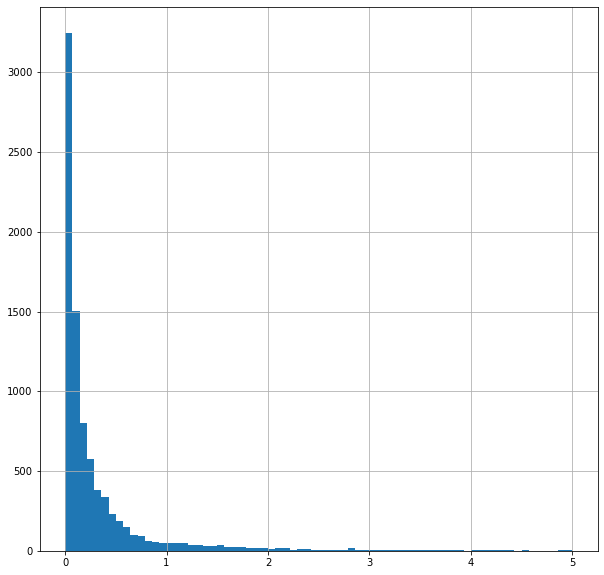

In [16]:
(data_critic_missed['na_sales'] + data_critic_missed['jp_sales'] + data_critic_missed['eu_sales'] + data_critic_missed['other_sales']).hist(bins = 70, figsize = (10,10),range = (0,5))

In [17]:
data_critic_not_user_missed = data.loc[(data['critic_score'].isna()) & (~ data['user_score'].isna())]

In [18]:
print('The number of omissions in the evaluation from critics for games that have a rating from users', data_critic_not_user_missed.shape[0])
data_critic_not_user_missed['user_score'].value_counts()

The number of omissions in the evaluation from critics for games that have a rating from users 1892


tbd    1322
7.8      26
8        23
7        23
7.6      19
       ... 
0.6       1
1.7       1
0         1
9.5       1
0.9       1
Name: user_score, Length: 85, dtype: int64

<AxesSubplot:>

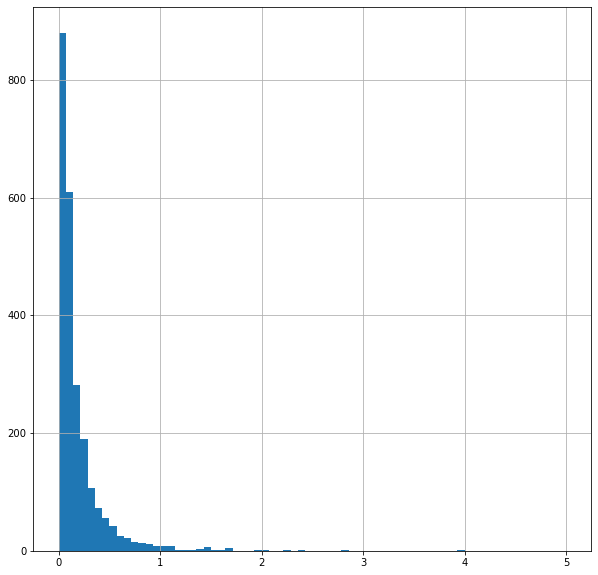

In [19]:
data_tbd_user_score = data[data['user_score'] == 'tbd']
(data_tbd_user_score['na_sales'] + data_tbd_user_score['jp_sales'] + data_tbd_user_score['eu_sales'] + data_tbd_user_score['other_sales']).hist(bins = 70, figsize = (10,10),range = (0,5))

Based on the data obtained, it can be concluded that the omissions in both rating columns are mainly for unpopular games on these platforms, which is quite logical, and the omissions are only in the critics ratings column in most games that have tbd' in the 'user_score' column, which means that there are not enough user votes, to put a user rating, the values of 'tbd' in the user_score column can be regarded as Nan, again this means that the game on this platform (or in principle the game itself) did not interest users

In [20]:
data['user_score'] = data['user_score'].replace({'tbd' : np.NaN})
data['user_score'] = data['user_score'].astype('float')
sum(data['user_score'].isna())

8990

The evaluation of the game is a subjective thing, so we can fill in these gaps in the columns `user_score` and `critic_score` only if there is data about the same games on other platforms.

We will fill in the gaps if there are ratings from critics on other platforms and there are more than 2 of them and the standard deviation of these ratings is less than 1

In [21]:
data_critic_score_not_null = data.loc[~data['critic_score'].isna()]

In [22]:
def fill_critic (x):
    if(not pd.isnull(x['critic_score'])):
        return x['critic_score']
    name = x['name']
    if(data_critic_score_not_null[data_critic_score_not_null['name'] == name].shape[0] > 2) and (np.std(data_critic_score_not_null[data_critic_score_not_null['name'] == name]['critic_score']) < 1):
        return data_critic_score_not_null[data_critic_score_not_null['name'] == name]['critic_score'].mean()
    return x['critic_score']
data['critic_score'] = data.apply(fill_critic, axis = 1)
sum(data['critic_score'].isna())

8416

Similarly, fill in the gaps in the `user_score` column

In [23]:
data_user_score_not_null = data.loc[~data['user_score'].isna()]

In [24]:
count = 0
for name in data[data['user_score'].isna()]:
    if(data_user_score_not_null[data_user_score_not_null['name'] == name].shape[0] > 2) and (np.std(data_user_score_not_null[data_user_score_not_null['name'] == name]['user_score']) < 1):
        count += 1
print(count)

0


Unfortunately, user ratings vary quite a lot in order to fill in the gaps, therefore `user_score` remains unfilled

Now consider the omissions in the `rating` column

In [25]:
data_rating_missed = data[data['rating'].isna()]
data_rating_missed

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


The omissions in the age rating column may be due to the fact that the rating could not have been set by ESRB (mostly common in America), or the game is too old, so it does not have a rating, since ESRB started working in 1994

In [26]:
data_rating_not_null = data[~data['rating'].isna()]
strange_rating_names = []
count = 0
for name in data['name']:
    if(len(data_rating_not_null[data_rating_not_null['name'] == name]['rating'].unique()) > 1):
        strange_rating_names.append(name)
print('The number of games with different age restrictions ', len(strange_rating_names))

The number of games with different age restrictions  709


Since manufacturers mostly try to make the same game on different platforms approximately the same, we can fill in the gaps if there is data on ratings on other platforms. However, games may have different restrictions on different platforms, which may depend on the difference in the versions of the game on different platforms, for example, due to changes in the company overseeing the development or due to the fact that the release year of versions on different platforms is very different, respectively, restrictions on each version could be obtained separately, we will fill in the gaps only if the year of the nearest version about which there is information differs by a maximum of 2 years and if all previous versions had the same age limit

In [27]:
def fill_rating(x):
    if(not pd.isnull(x['rating'])):
        return x['rating']
    name = x['name']
    if (len(data_rating_not_null[data_rating_not_null['name'] == name]) > 1) and (not pd.isnull(x['year_of_release'])):
        temp_list = list(data_rating_not_null[data_rating_not_null['name'] == name]['year_of_release'].dropna())
        temp_list.append(x['year_of_release'])
        temp_list = sorted(temp_list)
        index_x = temp_list.index(x['year_of_release'])
        one = abs(temp_list[(index_x-1  if index_x > 0 else index_x)] - x['year_of_release'] + (3000 if index_x == 0 else 0))
        two = abs(temp_list[(index_x+1 if index_x + 1 < len(temp_list) else index_x )] - x['year_of_release'] + (3000 if index_x +1 == len(temp_list) else 0))
        if (min(abs(temp_list[(index_x-1  if index_x > 0 else index_x)] - x['year_of_release'] + (3000 if index_x == 0 else 0)), abs(temp_list[(index_x+1 if index_x + 1 < len(temp_list) else index_x )] - x['year_of_release'] + (3000 if index_x +1 == len(temp_list) else 0))) <=2 )\
         and (len(data_rating_not_null[data_rating_not_null['name'] == name]['rating'].unique()) == 1):
            return data_rating_not_null[data_rating_not_null['name'] == name]['rating'].unique()[0]
    return x['rating']

data['rating'] = data.apply(fill_rating, axis = 1)
sum(data['rating'].isna())

6544

In order to analyze these games together with those rated in the future, we will fill in the gaps with the value 'No rating'

In [28]:
data['rating'] = data['rating'].fillna('No rating')
len(data[data['rating'].isna()])

0

Let's look at the gaps in the `name` column

In [29]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,No rating
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,No rating


It can be assumed that the first game is Mortal Combat 2, the second one is one of those that were sold only in Japan. However, since these games were released in 1993, they are no longer relevant for forecasting sales for 2017, so we will delete this data

In [30]:
data = data.dropna(subset = ['name'])

Next, let's look at the data types in the dataset

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16470 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16470 non-null  object 
 1   platform         16470 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16470 non-null  object 
 4   na_sales         16470 non-null  float64
 5   eu_sales         16470 non-null  float64
 6   jp_sales         16470 non-null  float64
 7   other_sales      16470 non-null  float64
 8   critic_score     8056 non-null   float64
 9   user_score       7482 non-null   float64
 10  rating           16470 non-null  object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


The float type is not suitable for describing the year, however, due to the fact that there are omissions in this column, we cannot replace the type there, all other data types are correct

For the convenience of further work, we will create a column with the total number of games sold

In [32]:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,No rating,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,No rating,31.38


## Exploratory data analysis

Let's see how many games were released in different years

In [33]:
data.pivot_table(index = 'year_of_release', values = 'na_sales',aggfunc='count').sort_values(by = 'na_sales')

,na_sales
year_of_release,
1980.0,9
1984.0,14
1985.0,14
1988.0,15
1990.0,16
1987.0,16
1989.0,17
1983.0,17
1986.0,21


Text(0, 0.5, 'Amount')

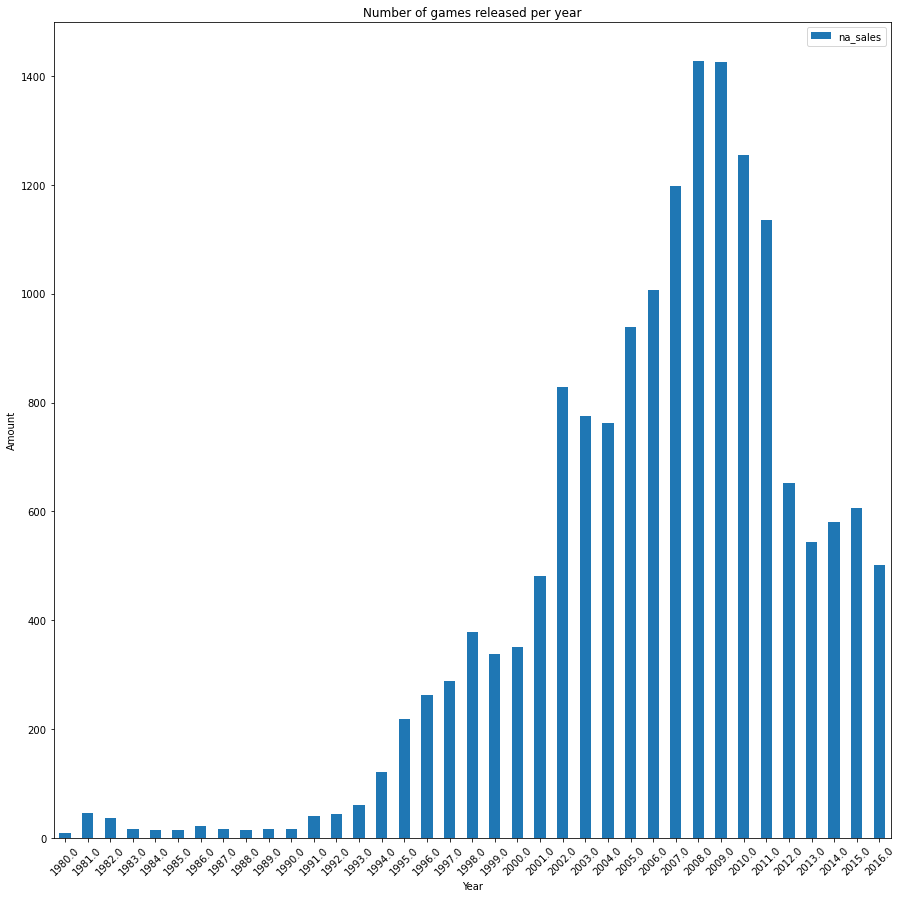

In [34]:
data.pivot_table(index = 'year_of_release', values = 'na_sales',aggfunc='count').plot(kind = 'bar', rot = 45, figsize = (15,15))
plt.title('Number of games released per year')
plt.xlabel('Year')
plt.ylabel('Amount')

According to the schedule, we see that the peak of the release of games was in 2007-2011, after 2011 we see a sharp decline in the release of games

Next, let's see how the sales of games by platform have changed

In [35]:
data.pivot_table(index = 'platform', values = 'total_sales',aggfunc='sum').sort_values(by = 'total_sales',ascending = False)

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


Platforms with the highest sales - PS2, X360, PS3, Wii,DS

Let's look at the distribution of sales by year on these platforms

In [36]:
top_platforms = ['PS2', 'X360', 'PS3', 'Wii','DS']
data_top_platforms = data.loc[data['platform'].isin(top_platforms)].pivot_table(index = ['platform','year_of_release'], values = 'total_sales', aggfunc='sum').reset_index()

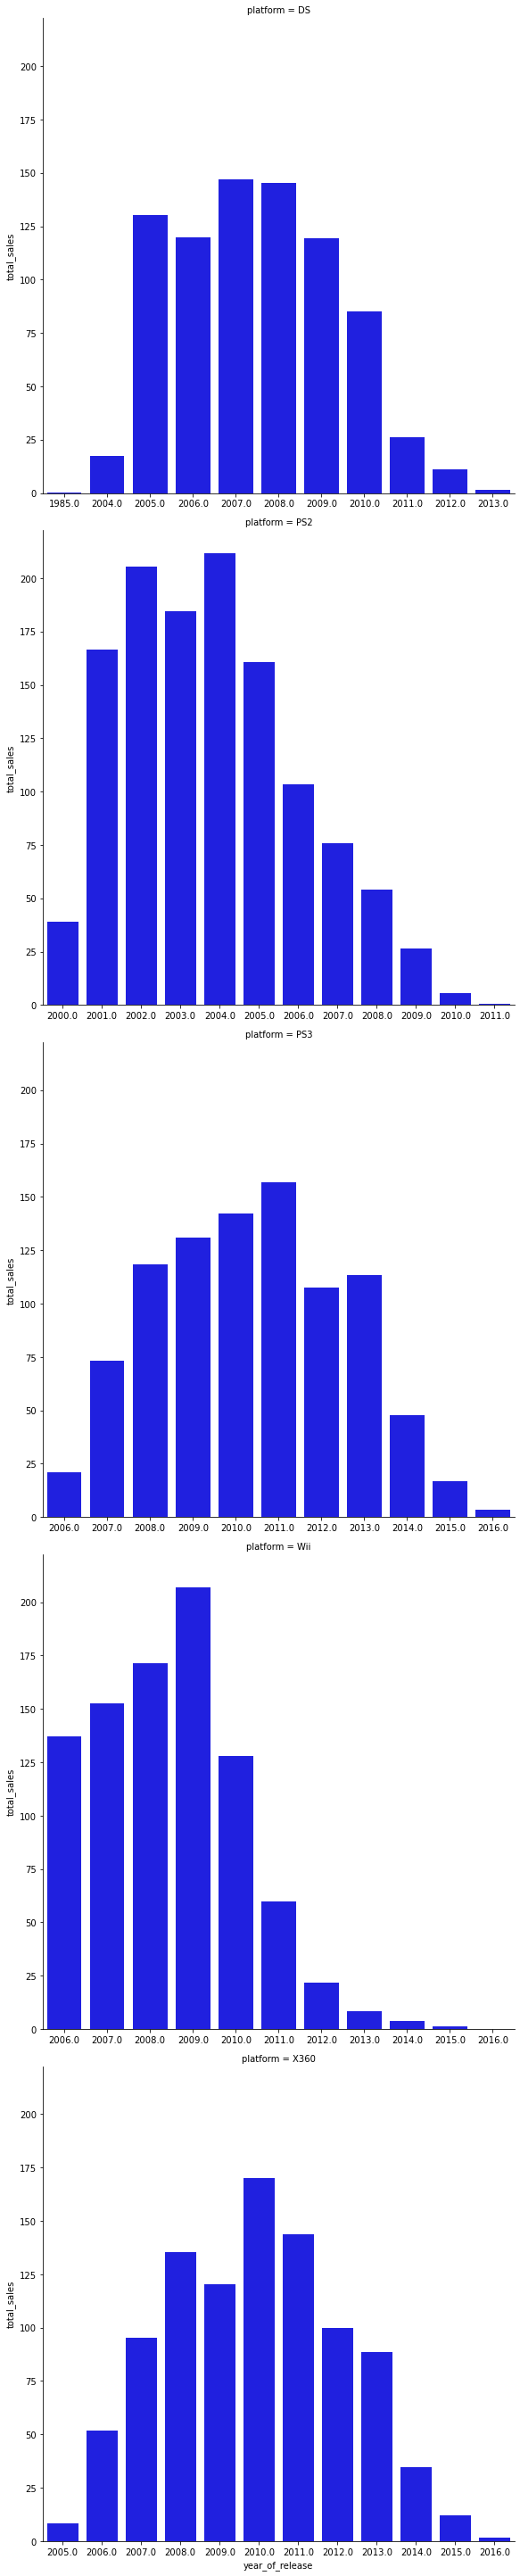

In [37]:
g = sns.catplot(x="year_of_release", y='total_sales', row="platform",
                   data=data_top_platforms,kind ='bar', color = 'blue',height = 8, sharex = False)

We see that these platforms have sales of new games for 2016 either zero or very small compared to sales earlier, if the dynamics continues, then it will be possible to state the fact that the life span of each of the platforms is about 10-12 years, then they are most likely already out of fashion and they are replaced by more modern platforms. It should be noted that for popular platforms, the peak of sales is reached for 4-6 years, then the dynamics is already on the decline.

Also strange is the year 1985 on the DS platform, since the release date of this platform on the market is 2004, there is no other data about this game in our dataset, and it also has a lot of gaps in the columns, so we will delete this game

In [38]:
data.loc[(data['year_of_release'] == 1985) & (data['platform'] == 'DS')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985.0,Action,0.0,0.0,0.02,0.0,NaN,NaN,No rating,0.02


In [39]:
data[data['name'] == 'Strongest Tokyo University Shogi DS']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985.0,Action,0.0,0.0,0.02,0.0,NaN,NaN,No rating,0.02


In [40]:
data = data[data['name'] != 'Strongest Tokyo University Shogi DS']

In [41]:
statistic = data.pivot_table(index = 'platform', values = 'year_of_release', aggfunc=['min','max'])
statistic.columns = ['min_year','max_year']
statistic['actual_years'] = statistic['max_year'] - statistic['min_year'] + 1
statistic

,min_year,max_year,actual_years
platform,,,
2600,1980.0,1989.0,10.0
3DO,1994.0,1995.0,2.0
3DS,2011.0,2016.0,6.0
DC,1998.0,2008.0,11.0
DS,2004.0,2013.0,10.0
GB,1988.0,2001.0,14.0
GBA,2000.0,2007.0,8.0
GC,2001.0,2007.0,7.0
GEN,1990.0,1994.0,5.0


<AxesSubplot:xlabel='year_of_release'>

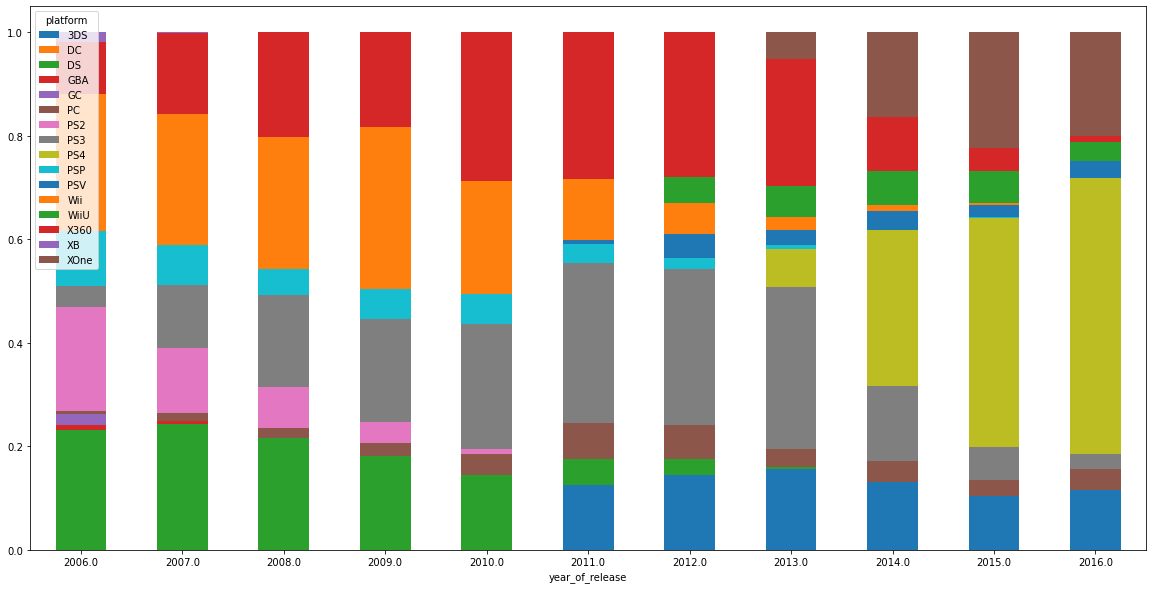

In [42]:
data = data[data['year_of_release']>=2006]
cross_tab_prop = pd.crosstab(index=data['year_of_release'],
                             columns=data['platform'],
                             values = data['total_sales'],
                             aggfunc='sum',
                             normalize="index")
cross_tab_prop.plot.bar(rot = 0,figsize = (20,10), stacked = True)

Since we need to predict sales for 2017, we will not consider games until 2006, since they were either released on an outdated platform now, or if they were popular, that is, most likely the next part of this game, possibly on a more modern platform, and then this part is irrelevant, and if this game is old and also unpopular, then with a high probability it will not be interested in 2017. 
Also considering that we forecast sales for 2017, and usually for forecasting tasks, especially in such a changeable industry, they use data for the last 2-4 years, and since 2012 there have been big changes in the structure of the market - a sharp decline in the number of new games, and if we consider games before 2012, the difference in the number of sales in 2007-2011 and 2012-2016 may give inaccurate results, and we also see that in 2011-2012 the structure of the market begins to change in terms of the popularity of platforms.

In [43]:
data = data[data['year_of_release'] >= 2012]
len(data)

2886

Now, in the time period that is relevant for us, let's see which platforms are leading in sales

In [44]:
data.pivot_table(index = 'platform', values = 'total_sales',aggfunc='sum').sort_values(by = 'total_sales',ascending = False)

,total_sales
platform,
PS4,314.14
PS3,288.79
X360,236.54
3DS,194.61
XOne,159.32
WiiU,82.19
PC,62.65
PSV,49.18
Wii,35.37


The leading selling platforms are PS4, PS3, X360,3DS, XOne. It should also be noted that, as expected, the number of platforms has significantly decreased

Let's look at the dynamics of sales on these 5 platforms

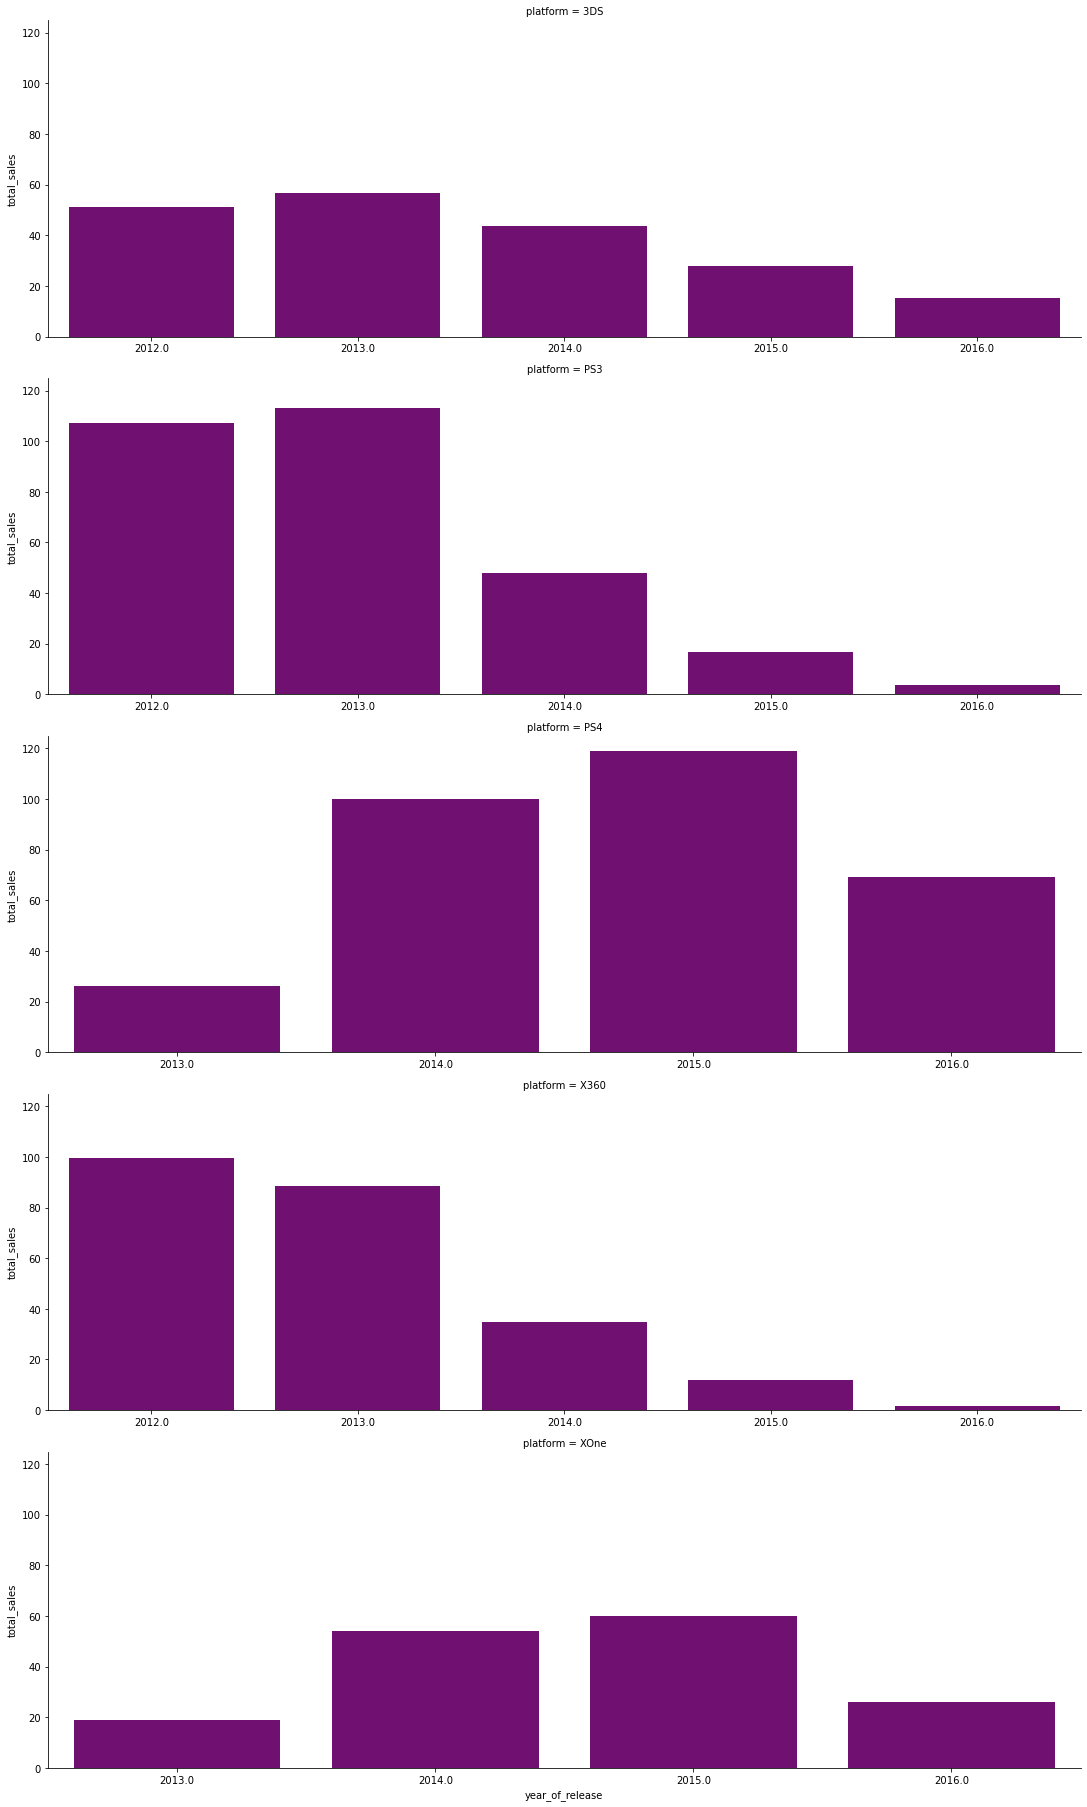

In [45]:
top_platforms = ['X360','PS3','XOne','3DS','PS4']
data_top_platforms = data.loc[data['platform'].isin(top_platforms)].pivot_table(index = ['platform','year_of_release'], values = 'total_sales', aggfunc='sum').reset_index()
g = sns.catplot(x="year_of_release", y='total_sales', row="platform",
                   data=data_top_platforms,kind ='bar', color = 'purple',height = 5, sharex = False, aspect = 3)

After that, it should be noted that since the data for 2016 is incomplete, we cannot draw conclusions about the decline in the number of sales of this year's game, however, we can note an increase in sales for the XOne, PS4 platforms for 2013-2015, a drop in sales for the X360, PS3 platforms, and a slight decline in the 3DS platform, a drop in X360 platforms,PS3 and the growth of XOne, PS4 can be explained by the fact that XONE is to replace X360, and PS4 is to replace PS3

<AxesSubplot:xlabel='year_of_release'>

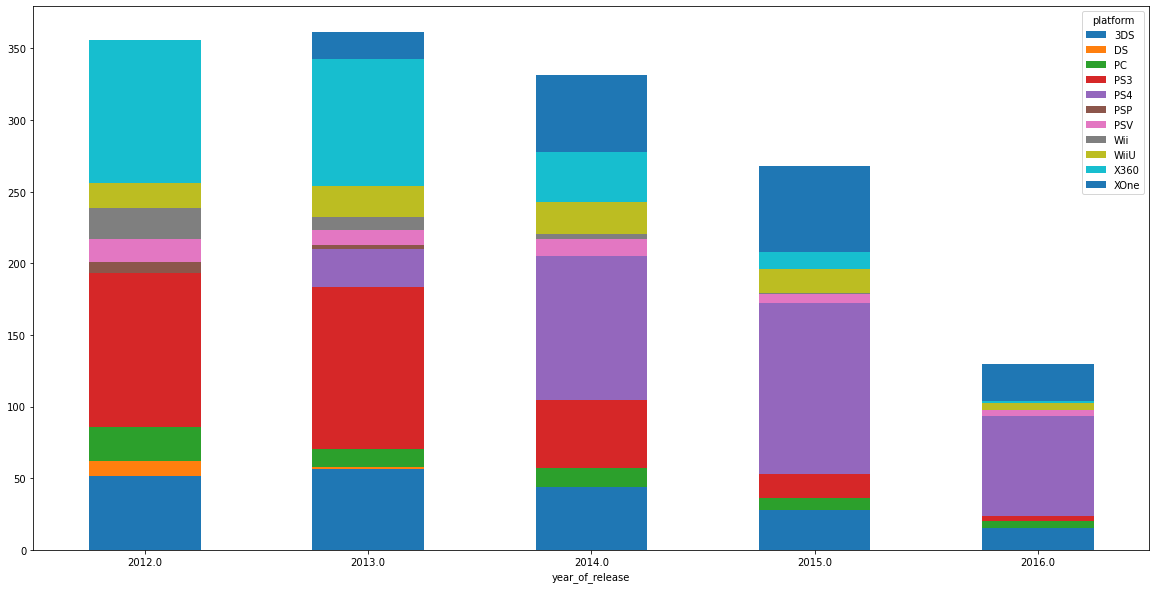

In [46]:
data.pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc='sum').fillna(0).plot.bar(rot = 0,figsize = (20,10), stacked = True)

As we can see from the graph - the PS4, 3DS, XOne platforms are the most promising. Games on other platforms are released much less (or not at all), which indicates that the platform has lost relevance, or modern games on these platforms are not bought, which also indicates that it is unpromising. The prospects of these platforms are also indicated by the fact that they are the successors of the older very popular platforms PS3, DS, X360

Consider the global sales of games by platform

<AxesSubplot:xlabel='platform', ylabel='total_sales'>

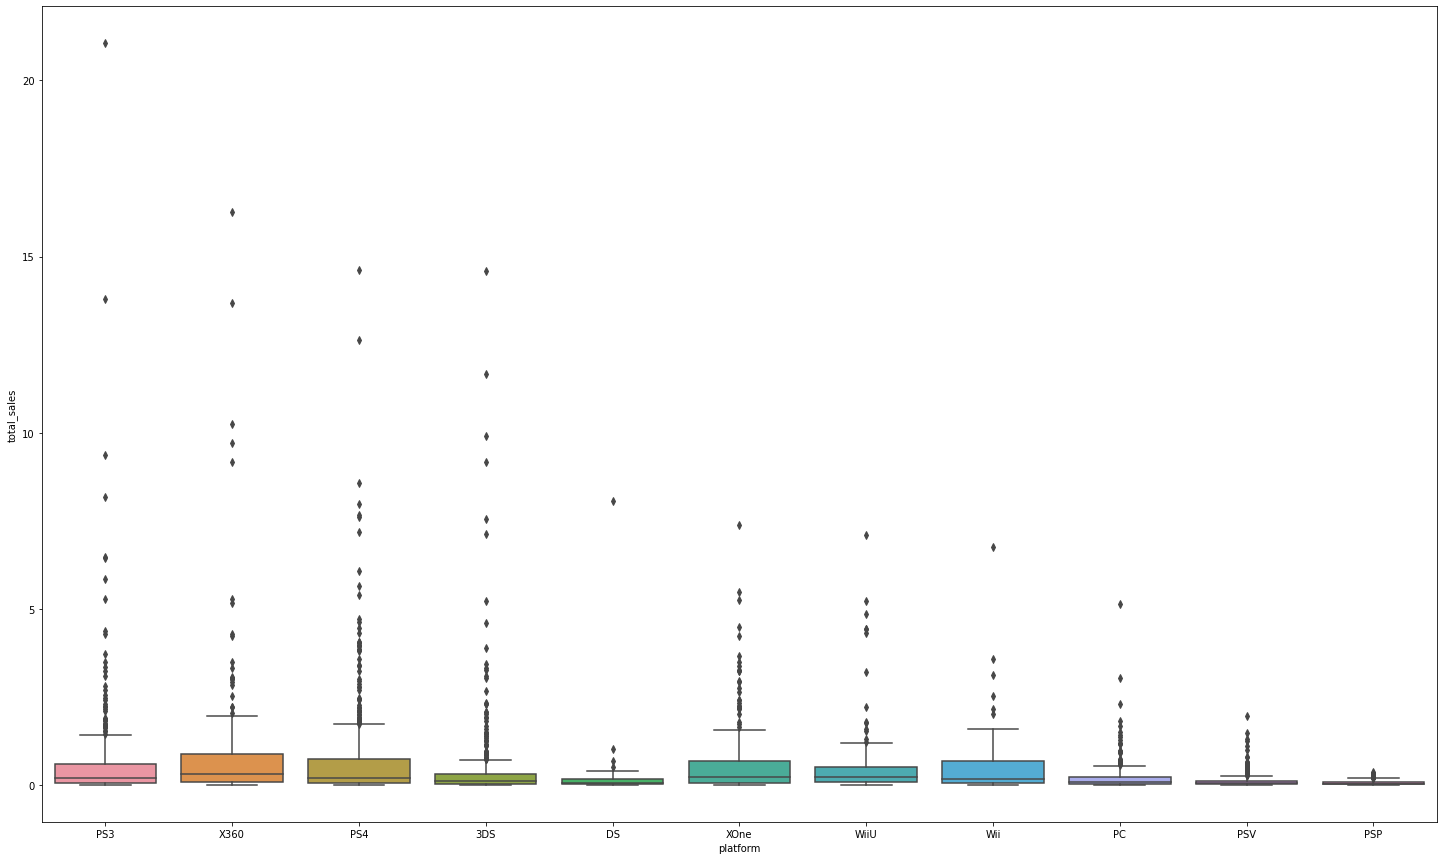

In [47]:
plt.figure(figsize=(25,15))
sns.boxplot(x = 'platform', y = 'total_sales', data = data)

In [48]:
data[data['total_sales'] > 20]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05


Grand Theft Auto V is the undisputed leader in games by sales, let's take into account that there are such outstanding emissions on the chart, perhaps part of the budget can be directed to advertising these very popular games, and consider the bulk of games (without emissions)

<AxesSubplot:xlabel='platform', ylabel='total_sales'>

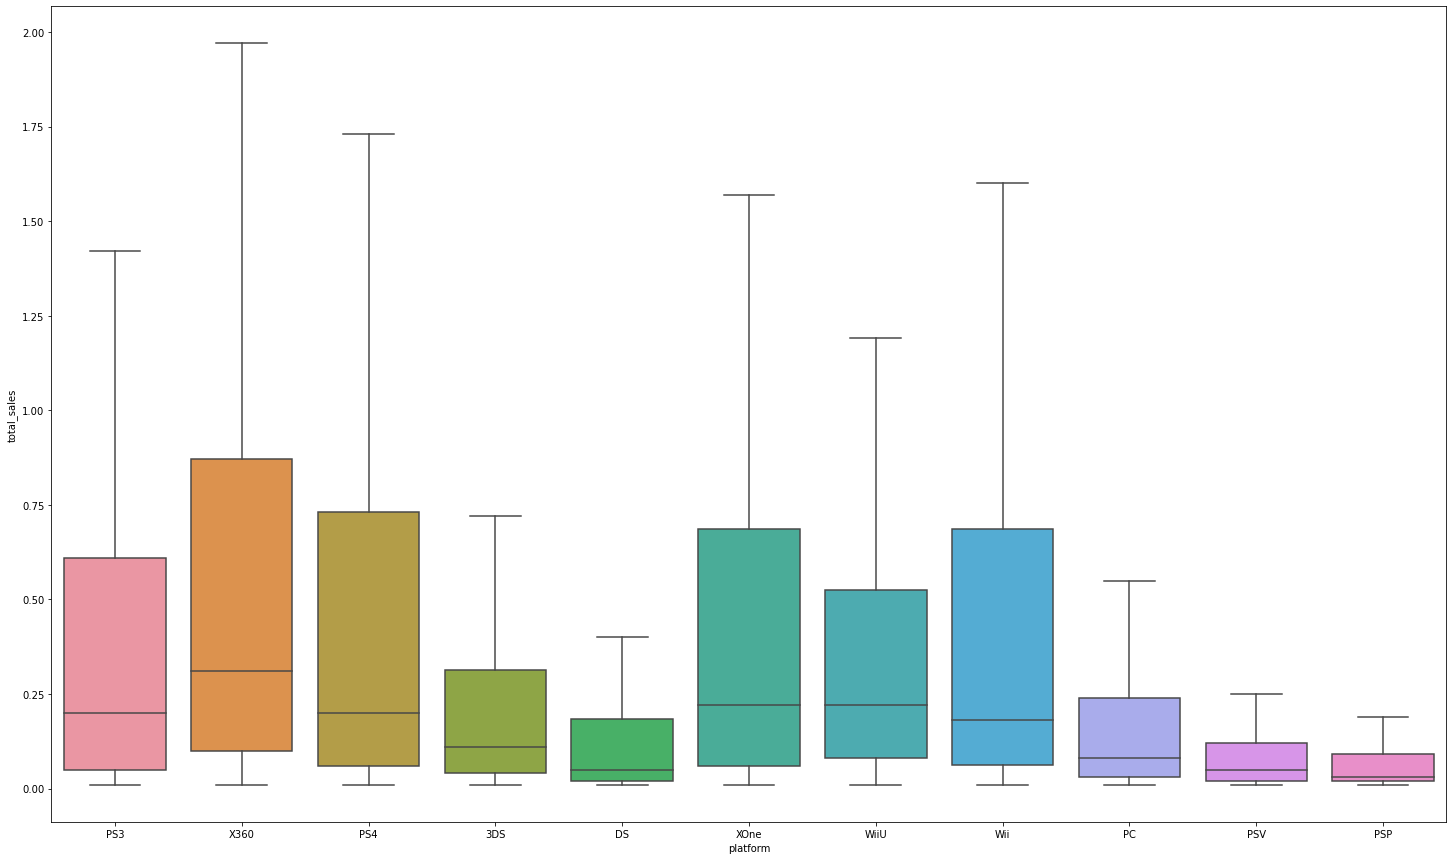

In [49]:
plt.figure(figsize=(25,15))
sns.boxplot(x = 'platform', y = 'total_sales', data = data,showfliers = False)

We see that basically the median value of the total number of sales for all platforms is quite low, this suggests that most games do not make a splash, but it should be noted that almost every platform has huge outliers. It should also be noted that the XOne, X360 platforms have one of the largest medians and quartiles, the lowest are for PSP, PSV, DS, since in the period since 2012 PSP and DS were already considered obsolete, and the PSV platform simply did not enjoy as much demand as, for example, the same XOne

In [50]:
top_for_platforms = data.groupby('platform')[['name','total_sales','platform']].head(5).sort_values(by = 'platform')
np.sort(list(top_for_platforms['name']))

array([" Frozen: Olaf's Quest", 'Animal Crossing: New Leaf',
       "Assassin's Creed III: Liberation",
       'Call of Duty Black Ops: Declassified',
       'Call of Duty: Advanced Warfare', 'Call of Duty: Advanced Warfare',
       'Call of Duty: Black Ops 3', 'Call of Duty: Black Ops 3',
       'Call of Duty: Black Ops II', 'Call of Duty: Black Ops II',
       'Call of Duty: Ghosts', 'Call of Duty: Ghosts',
       'Dai-2-Ji Super Robot Taisen Z Saisei-hen', 'Diablo III',
       'FIFA 14', 'FIFA 16', 'FIFA Soccer 13', 'FIFA Soccer 13',
       'Fallout 4', 'Grand Theft Auto V', 'Grand Theft Auto V',
       'Grand Theft Auto V', 'Grand Theft Auto V', 'Guild Wars 2',
       'Halo 4', 'Halo 5: Guardians', 'Just Dance 2014', 'Just Dance 4',
       'LEGO Batman 2: DC Super Heroes', 'LittleBigPlanet PS Vita',
       'Mario Kart 8', 'Mario Party 9', 'Minecraft', 'Minecraft',
       'Moshi Monsters: Moshlings Theme Park', 'New Super Mario Bros. 2',
       'New Super Mario Bros. U', 'Nintendo L

In [51]:
(top_for_platforms.sort_values(by = 'name'))

,name,total_sales,platform
3862,Frozen: Olaf's Quest,0.51,DS
73,Animal Crossing: New Leaf,9.17,3DS
1485,Assassin's Creed III: Liberation,1.31,PSV
1294,Call of Duty Black Ops: Declassified,1.47,PSV
92,Call of Duty: Advanced Warfare,7.66,PS4
179,Call of Duty: Advanced Warfare,5.26,XOne
31,Call of Duty: Black Ops 3,14.63,PS4
99,Call of Duty: Black Ops 3,7.39,XOne
34,Call of Duty: Black Ops II,13.79,PS3
35,Call of Duty: Black Ops II,13.68,X360


As we can see, a lot of games are repeated, it means that in the top of all platforms, there are mostly just popular games that are known and sold on many other platforms

Let's look at the most profitable platforms and look at the relationship between reviews and sales

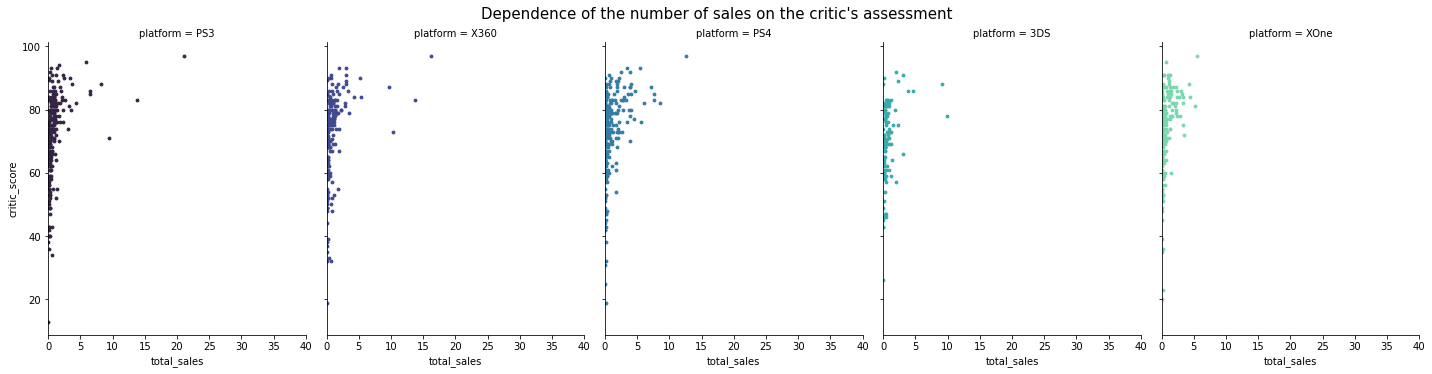

Correlation coefficient for the platform X360  равен =  0.35304486213952757
Correlation coefficient for the platform PS3  равен =  0.3284599949323674
Correlation coefficient for the platform XOne  равен =  0.4081030538671795
Correlation coefficient for the platform 3DS  равен =  0.3119282724976071
Correlation coefficient for the platform PS4  равен =  0.40360298218770574


In [52]:
g = sns.FacetGrid(data=data.loc[data['platform'].isin(top_platforms)], col='platform', height=5, aspect=0.8, hue = 'platform', palette='mako',xlim=(0,40))
g.map(plt.scatter, 'total_sales','critic_score', s = 8)
g.fig.suptitle('Dependence of the number of sales on the critic\'s assessment',
               y = 1.03,
               fontsize = 15)
plt.show()
for platform in top_platforms:
    print('Correlation coefficient for the platform', platform, ' равен = ', data[data['platform'] == platform]['total_sales'].corr(data[data['platform'] == platform]['critic_score'] ))

We see that in general the correlation is quite weak - there is no clear linear relationship between the critics' assessment and the number of sales, however, it should be noted that if the game's score is less than 60 from the critic, then it is unpopular, and all popular games mostly have a score of more than 60-65, there are also a lot of games that have an excellent score from critics, but at the same time its sales are very small, therefore a good rating from a critic only expands the ceiling of possible sales, but it is still quite likely that the game will not be popular.

The XOne platform has the largest correlation coefficient (the most linear dependence), 3DS has the lowest, and it should also be noted that 3DS platform games are given quite a few good ratings. It should also be noted that the top X360, PS3 and PS4 games were "predicted" by critics most accurately

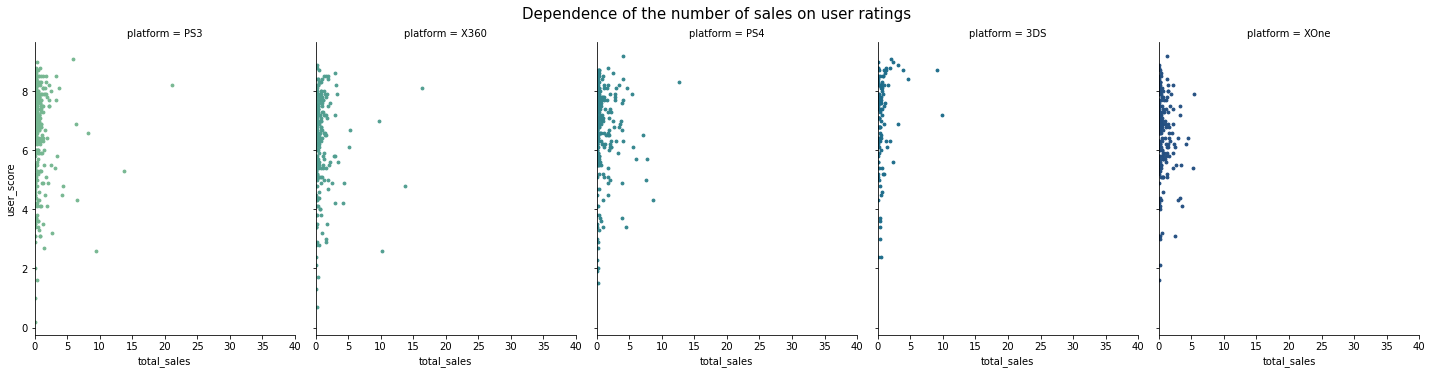

Correlation coefficient for the platform X360  равен =  0.0061639786462133256
Correlation coefficient for the platform PS3  равен =  -0.005143522887113816
Correlation coefficient for the platform XOne  равен =  -0.06892505328279412
Correlation coefficient for the platform 3DS  равен =  0.19758263411038596
Correlation coefficient for the platform PS4  равен =  -0.031957110204556424


In [53]:
g = sns.FacetGrid(data=data.loc[data['platform'].isin(top_platforms)], col='platform', height=5, aspect=0.8, hue = 'platform', palette='crest',xlim=(0,40))
g.map(plt.scatter, 'total_sales','user_score', s = 8)
g.fig.suptitle('Dependence of the number of sales on user ratings',
               y = 1.03,
               fontsize = 15)
plt.show()
for platform in top_platforms:
    print('Correlation coefficient for the platform', platform, ' равен = ', data[data['platform'] == platform]['total_sales'].corr(data[data['platform'] == platform]['user_score'] ))

The dependence on user ratings is even weaker, the PS4 and XOne platforms have an unexpectedly negative correlation coefficient in general, but we can still say that if the user rating is less than 4, then these are mostly unpopular (by sales) games, but at the same time the PS4,PS3 platforms have quite low ratings for popular games (there are even games with a score less than 3), popular games of the 3DS platform are rated quite high, although critics rarely give this platform high marks. 

Such low correlation coefficients for the relationship between the number of sales and user evaluation appeared due to the fact that a lot of users with absolutely opposite opinions give ratings, plus if the game is popular - of those who liked it and who are dissatisfied, a much larger percentage of dissatisfied will give a low rating than the percentage of satisfied will give a high one, respectively, this will underestimate the average rating of the game, also very often players focus on several points and either admire them, or on the contrary are indignant, unlike critics who look at the picture in general, paying attention even to unimportant for somebody aspects of the game , the ratings from critics are also less chaotically arranged, because critics are professionals, with a built-in system, their view and the view of an ordinary user are two different things.

Now let's look at the distribution of games by genre

<AxesSubplot:xlabel='genre'>

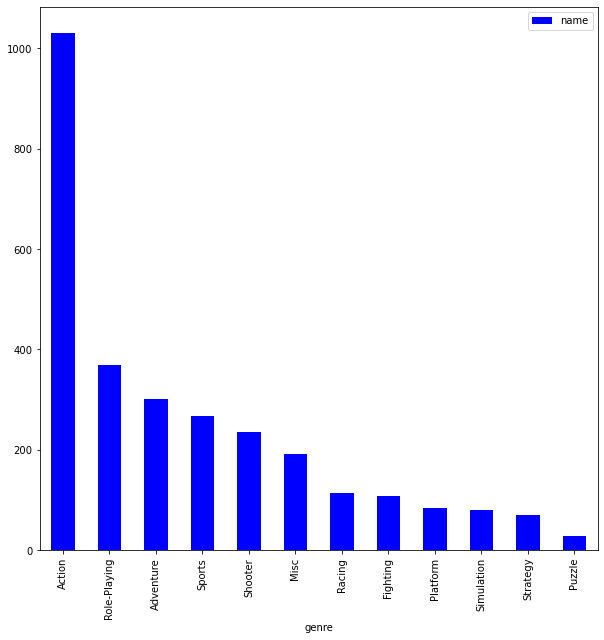

In [54]:
data.pivot_table(index = 'genre', values = 'name', aggfunc='count').sort_values(by = 'name',ascending = False).plot.bar(figsize = (10,10), color = 'blue')

The peak value for the action genre can be explained by the fact that fighting games, shooters and platformers also belong to action genre, therefore, since action is a cumulative genre, then the number of games for it should be more. The least games come out in fairly narrowly focused genres - simulators, puzzles and strategies (it is important to note that many games of the fighting games genre, shooters and so on can be attributed to strategies too, a purely strategic game is still a narrowly focused genre), most games come out in the genres of action, role-playing and adventure

<AxesSubplot:xlabel='year_of_release'>

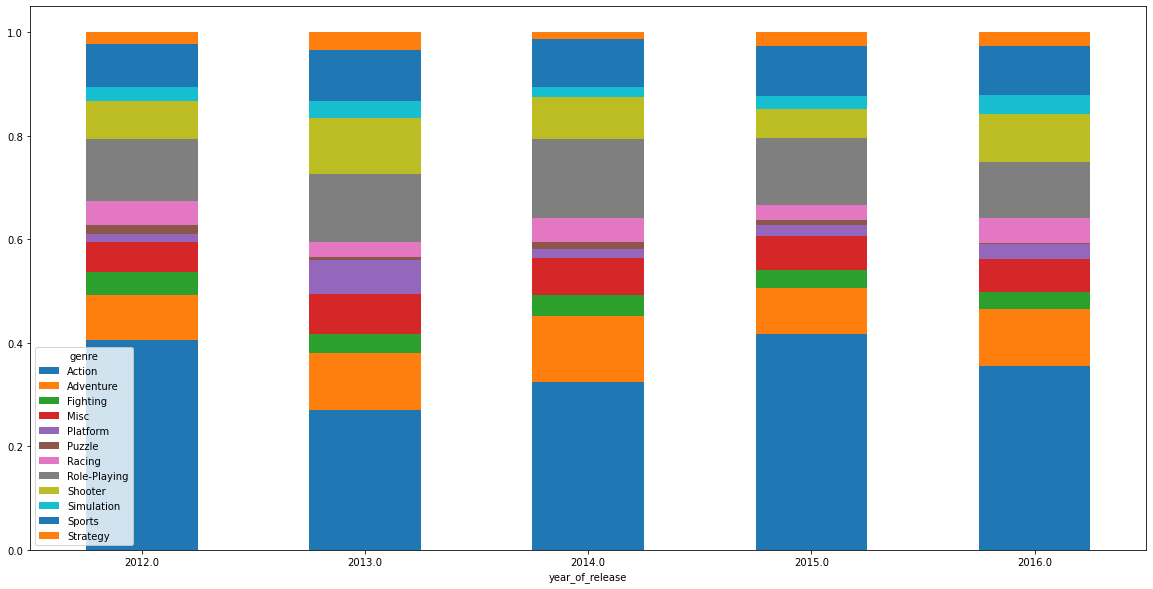

In [55]:
cross_tab_prop = pd.crosstab(index=data['year_of_release'],
                             columns=data['genre'],
                             values = data['name'],
                             aggfunc='count',
                             normalize="index")
cross_tab_prop.plot.bar(rot = 0,figsize = (20,10), stacked = True)

As we can see, at the moment the puzzles have almost lost their relevance, in recent years more action has been released, but otherwise the percentage by genre remains +- the same over the years. Let's look now at the percentage ratio for the number of sales

<AxesSubplot:xlabel='year_of_release'>

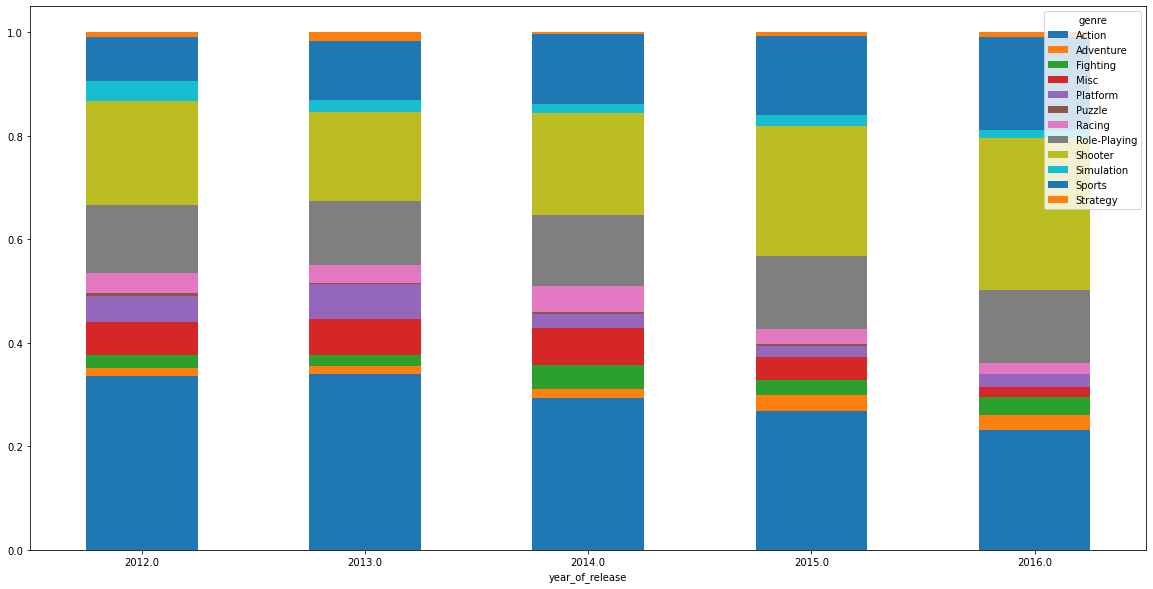

In [56]:
cross_tab_prop = pd.crosstab(index=data['year_of_release'],
                             columns=data['genre'],
                             values = data['total_sales'],
                             aggfunc= 'sum',
                             normalize="index")
cross_tab_prop.plot.bar(rot = 0,figsize = (20,10), stacked = True)

Shooters did not stand out in terms of the number of games released, but the trend is only going up in terms of the average number of copies sold, it turns out that shooter games are rarely released, but rather aptly, perhaps new shooters are more interesting than new games in the action genre, but still the lion's share of total copies sold consistently refers to action genre games, also, a fairly large percentage in all years refers to games in the genre of sports, platform games have begun to lose their relevance a little compared to 2012-2013.Adventure games are produced in a fairly large percentage, however, the percentage of copies sold is quite small. Accordingly, the least copies are sold in the genres of strategy, simulators and puzzles, and most of all - shooters, action, sports. However, it is also important to take into account the average number of copies sold in order to conclude about successful genres that take not the number of games produced, but the quality

<AxesSubplot:xlabel='year_of_release'>

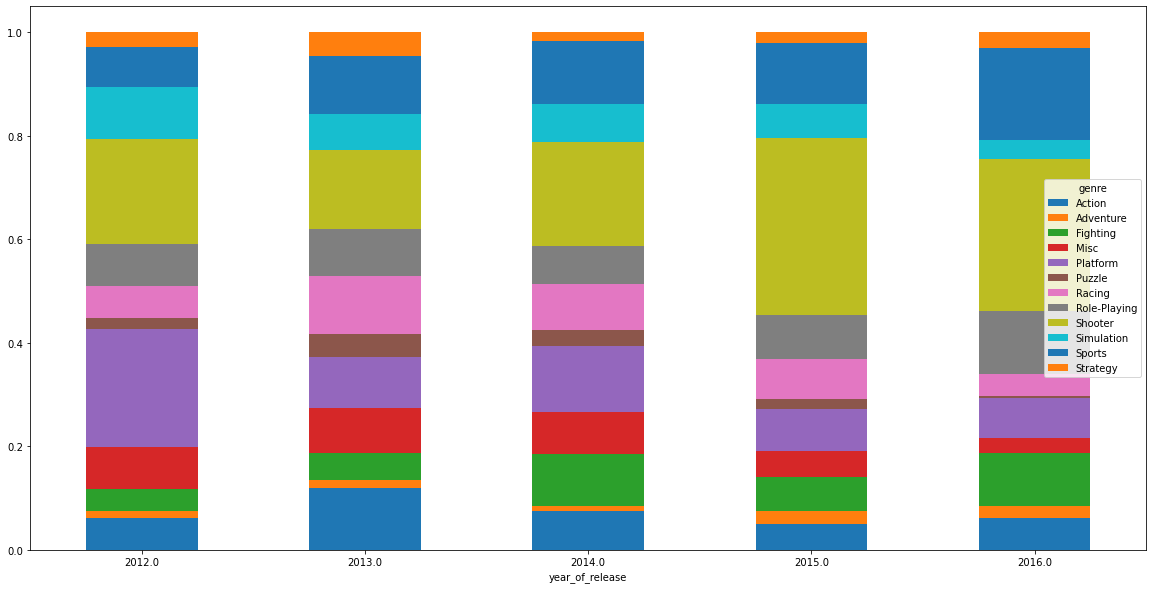

In [57]:
cross_tab_prop = pd.crosstab(index=data['year_of_release'],
                             columns=data['genre'],
                             values = data['total_sales'],
                             aggfunc= 'mean',
                             normalize="index")
cross_tab_prop.plot.bar(rot = 0,figsize = (20,10), stacked = True)

A lot of games have been consistently released in the action genre, but the average number of copies sold is unexpectedly small, so a lot of poorly sold games are being stamped in this genre, the shooter genre, as noted earlier, is very successful.  Unexpectedly successful, despite a small number of games, fighting and platformer genres have been released, apparently these are the genres ,which are no longer produced for mass production, but for fans of such genres, also games in such genres produce companies that specialize exatly in them, there are not very many such companies, but they make high-quality games. The genre of sports is also consistently quite successful. The most successful genres by the average number of copies sold: shooters, sports, platformers. The most unsuccessful - adventures and puzzles

Now let's analyze the box plots for each of the genres to compare how stable each of the genres is

<AxesSubplot:xlabel='genre', ylabel='total_sales'>

<Figure size 432x288 with 0 Axes>

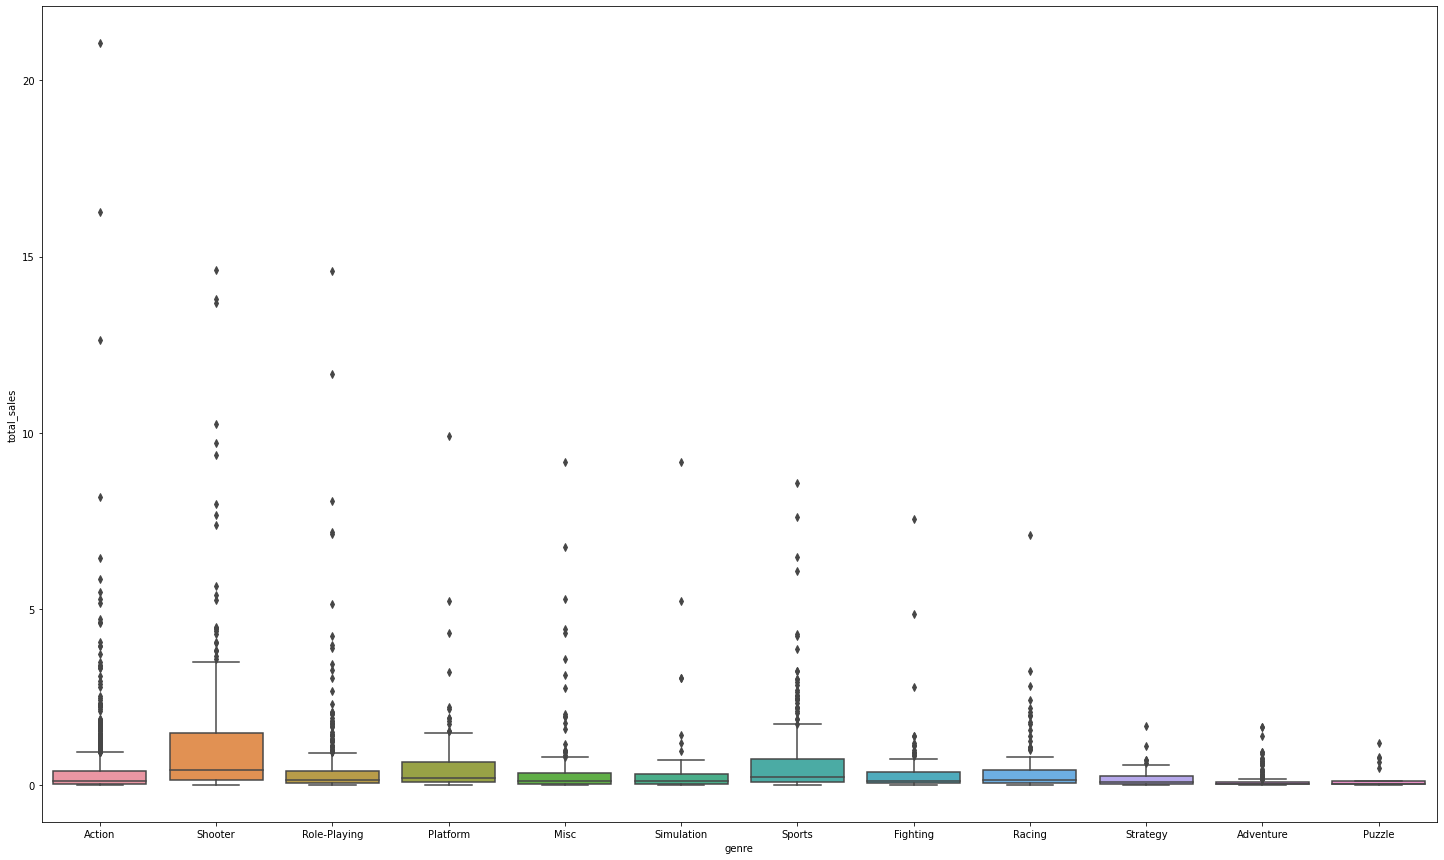

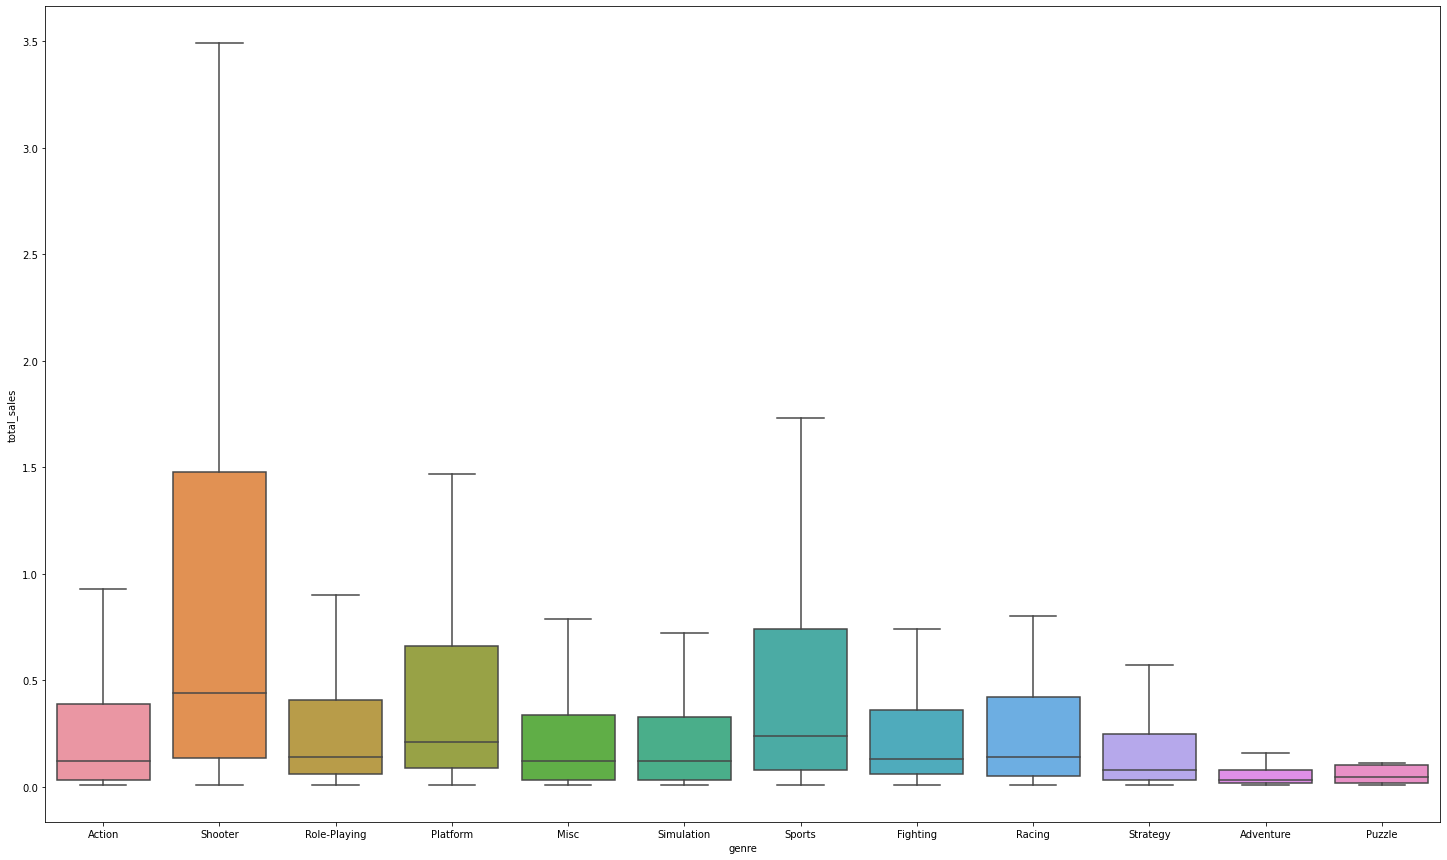

In [58]:
plt.figure(1)
plt.figure(figsize=(25,15))
sns.boxplot(x = 'genre', y = 'total_sales', data = data,showfliers = True)
plt.figure(2)
plt.figure(figsize=(25,15))
sns.boxplot(x = 'genre', y = 'total_sales', data = data,showfliers = False)

We see a large number of outliers in the genre of action and role-playing, shooters are also distinguished by large outliers, the most successful games are games in the genre of shooters, they have the largest quartiles, but despite this, the biggest run-up in sales, the most unsold genres are adventures, puzzles, they have the lowest quartiles, and they do not they differ in strong outliers, sports and platformer genres can also be called genres with well-selling games 

### User profile for each region

Let's look at the platforms that have the most games sold (for each region)

In [59]:
display(data.pivot_table(index = 'platform',values = 'na_sales', aggfunc= 'sum').sort_values(by = 'na_sales',ascending = False))
display(data.pivot_table(index = 'platform',values = 'eu_sales', aggfunc= 'sum').sort_values(by = 'eu_sales',ascending = False))
data.pivot_table(index = 'platform',values = 'jp_sales', aggfunc= 'sum').sort_values(by = 'jp_sales',ascending = False)

,na_sales
platform,
X360,140.05
PS4,108.74
PS3,103.38
XOne,93.12
3DS,55.31
WiiU,38.10
PC,19.12
Wii,17.45
PSV,10.98


,eu_sales
platform,
PS4,141.09
PS3,106.86
X360,74.52
XOne,51.59
3DS,42.64
PC,37.76
WiiU,25.13
Wii,11.92
PSV,11.36


,jp_sales
platform,
3DS,87.79
PS3,35.29
PSV,21.04
PS4,15.96
WiiU,13.01
PSP,10.47
DS,3.72
Wii,3.39
X360,1.57


<AxesSubplot:ylabel='platform'>

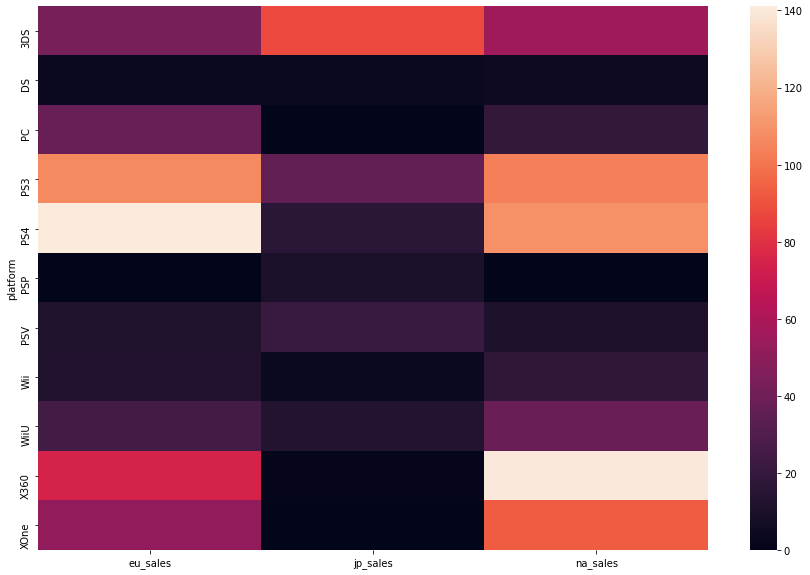

In [60]:
plt.figure(figsize=(15,10))
sns.heatmap(data.pivot_table(index = 'platform',values = ['na_sales','eu_sales','jp_sales'], aggfunc= 'sum'))

Top 5 popular platforms in America : X360, PS4, PS3, XOne, 3DS 

Top 5 platforms by the number of copies sold for Europe: PS4, PS3, X360, XOne, 3DS the list coincided with the list for America, except that PS4 and PS3 have a higher place in the top of Europe than America, and X360 has a higher place in America

The top platforms in Japan look different, the TOP 5 are 3DS, PS3,PSV,PS4,WiiU. PS4 in Japan was not as popular as in America and Europe, the total number of sales is 7 times less than in America. And 3DS in America and Europe was far from the first place. 2 out of 5 platforms in the top (1st and 3rd place) are "manual" consoles that fit more into the culture of Japan than the PS and XOne (X360) popular in America and Europe, and even considering how popular PS is in the world, and considering that Sony is Japanese company, they still made PS bet on the European and American markets, which caused discontent in Japan and relatively small sales of the PS4. 

As we can see from the heatmap, there are much fewer games sold in Japan than in other areas, and there are many platforms with very small sales in Japan, it is also worth noting that 3DS in Japan, PS4 in Europe and X360 in America are by a large margin from other platforms, also this heatmap clearly shows how much America and Europe agree on the choice of platforms and how Japan differs from them

In [61]:
region = ['na_sales','eu_sales','jp_sales']
dfs = []
for i in range(3):
    dfs.append(data.copy())
    top_platforms = list(data.pivot_table(index = 'platform',values = region[i], aggfunc= 'sum').sort_values(by = region[i],ascending = False).index)[:5]
    dfs[-1]['platform'] = dfs[-1]['platform'].where(dfs[-1]['platform'].isin( top_platforms), 'other')

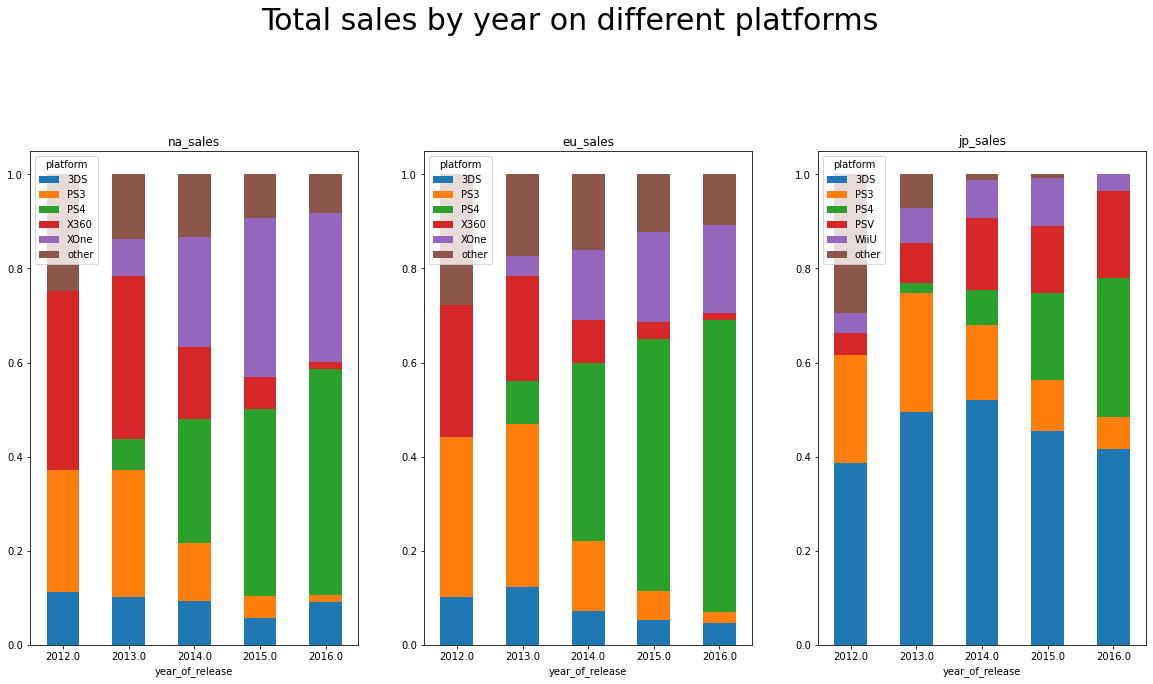

In [62]:
fig = plt.figure(figsize=(20,20))
fig.suptitle('Total sales by year on different platforms', fontsize = 30)
region = ['na_sales','eu_sales','jp_sales']
ax = []
for i in range(3):
    cross_tab_prop = pd.crosstab(index=dfs[i]['year_of_release'],
                                columns=dfs[i]['platform'],
                                values = dfs[i][region[i]],
                                aggfunc='sum',
                                normalize="index")
    ax1 = plt.subplot(2, 3, i+1)
    cross_tab_prop.plot.bar(ax=ax1,rot = 0, stacked = True)
    ax1.set_title(region[i])
plt.show()

America: The PS4 and XOne platform is very promising at the moment, X360 was extremely popular in 2012-2013, but now it has been replaced by XOne, PS3 sales have been consistently good for a long time, but PS3 has also been replaced by PS4, the percentage of sales of games on the 3DS platform remains stable.

Europe: In general, the picture is about the same as in America, but there are some peculiarities, for example, the PS3 was more popular in Europe among other platforms, the X360 did not cause such a furore that was in America, the XOne is also not as popular in Europe as in America. The most promising platorms remain, as in America - PS4 and XOne.

Japan: A completely different picture is visible in sales in the Japanese market, you can forget about the popularity of the X360, a huge percentage of sales from the PS4. The most promising platforms at the moment can be considered 3DS, PSV and PS4, although its percentage of sales does not compare with other regions. Interesting fact: the Japanese like to play on the road, so compact platforms are more important for them. PSP was popular in 2010-2011, but now PSV has come to replace it. DS enjoyed great popularity in 2006-2010, and then 3DS came to replace it.

Let's also look at the number of copies sold by year in each of the districts

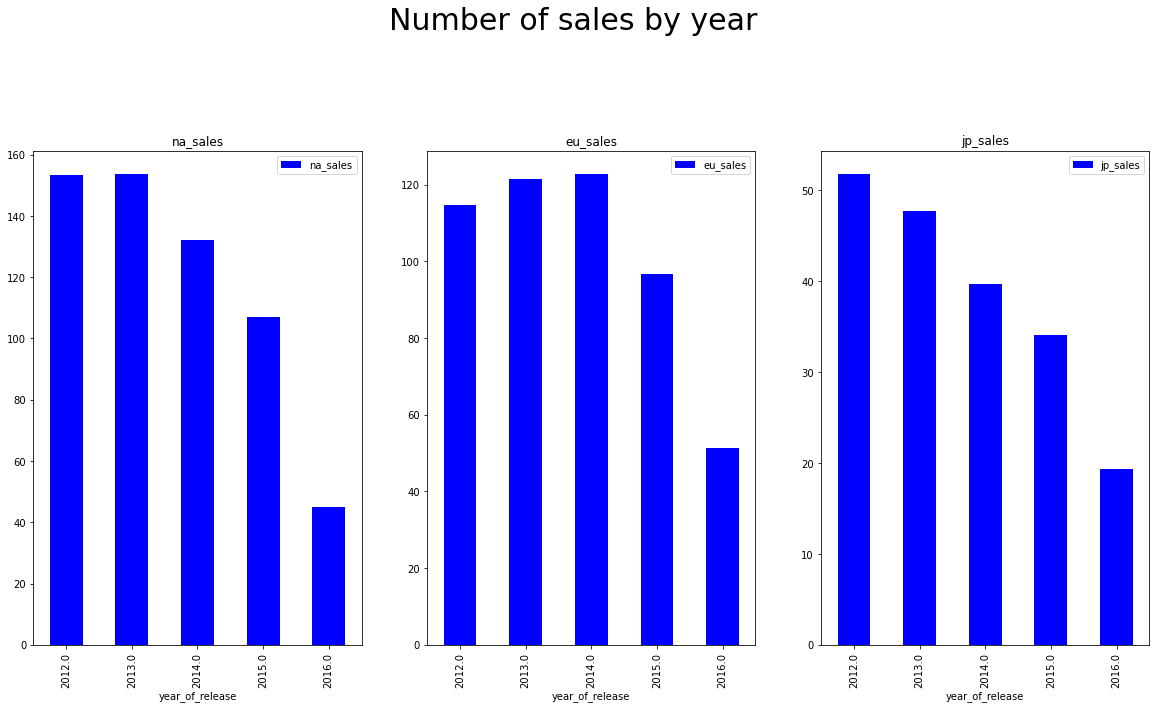

In [63]:
fig = plt.figure(figsize=(20,20))
fig.suptitle('Number of sales by year', fontsize = 30)
region = ['na_sales','eu_sales','jp_sales']
for i in range(3):
    ax1 = plt.subplot(2, 3, i+1)
    data.pivot_table(index = 'year_of_release', values = region[i], aggfunc='sum').plot.bar(ax = ax1, color = 'blue')
    ax1.set_title(region[i])
plt.show()

America: after 2013, a gradual decline in the number of sales is noticeable

Europe: the growth in the number of sales until 2014, in 2015, much fewer games were already sold

Japan: since 2012 we have seen a constant decline in the number of games sold

Now let's look at the most popular genres in the regions

In [64]:
display(data.pivot_table(index = 'genre',values = 'na_sales', aggfunc= 'sum').sort_values(by = 'na_sales',ascending = False))
display(data.pivot_table(index = 'genre',values = 'eu_sales', aggfunc= 'sum').sort_values(by = 'eu_sales',ascending = False))
display(data.pivot_table(index = 'genre',values = 'jp_sales', aggfunc= 'sum').sort_values(by = 'jp_sales',ascending = False))

,na_sales
genre,
Action,177.84
Shooter,144.77
Sports,81.53
Role-Playing,64.00
Misc,38.19
Platform,25.38
Fighting,19.79
Racing,17.22
Adventure,8.92


,eu_sales
genre,
Action,159.34
Shooter,113.47
Sports,69.09
Role-Playing,48.53
Racing,27.29
Misc,26.32
Platform,21.41
Simulation,14.55
Fighting,10.79


,jp_sales
genre,
Role-Playing,65.44
Action,52.80
Misc,12.86
Simulation,10.41
Fighting,9.44
Shooter,9.23
Platform,8.63
Adventure,8.24
Sports,8.01


<AxesSubplot:ylabel='genre'>

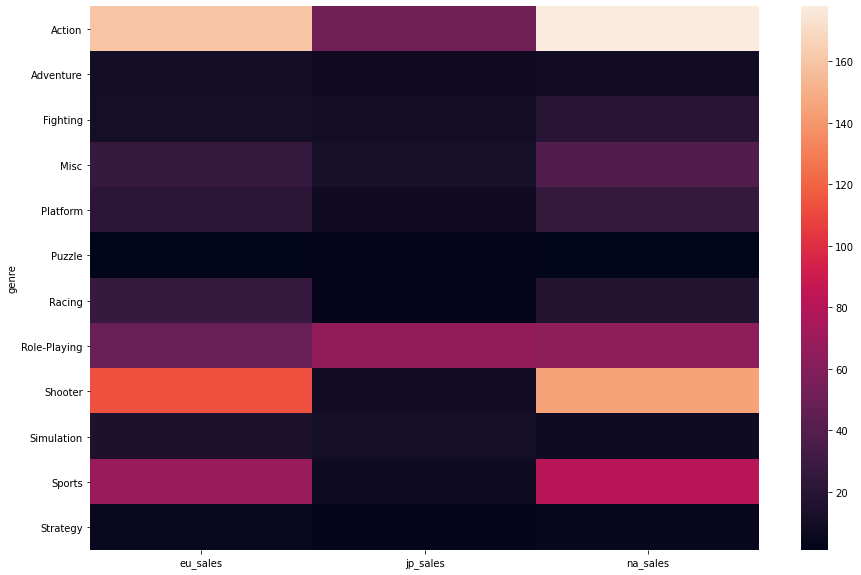

In [65]:
plt.figure(figsize=(15,10))
sns.heatmap(data.pivot_table(index = 'genre',values = ['na_sales','eu_sales','jp_sales'], aggfunc= 'sum'))

America: The top 5 genres include: action (by a large margin, presumably because it is a combined genre), shooters, sports, role-playing and games without a specific genre (others).

Europe: Top 5 genres - action, shooters, sports, role-playing, racing. The list is almost identical to the list for America, except that the races are more popular here

Japan: The composition of the top 5 genres differs from the European and American top: role-playing games come first, then action, others, simulators and fighting games. Sports and racing are at the end of the list, unlike America and Europe, which once again indicates that Japanese preferences in games are very different from European and American ones. Role-playing games are probably the most suitable for the character of the Japanese, there is even a separate branch of RPG - JRPG, in which the plots of the games are very similar to the plots of Japanese anime and are even closer to literature and cinema.

In [66]:
region = ['na_sales','eu_sales','jp_sales']
dfs = []
for i in range(3):
    dfs.append(data.copy())
    top_genres = list(data.pivot_table(index = 'genre',values = region[i], aggfunc= 'sum').sort_values(by = region[i],ascending = False).index)[:5]
    dfs[-1]['genre'] = dfs[-1]['genre'].where(dfs[-1]['genre'].isin( top_genres), 'other')

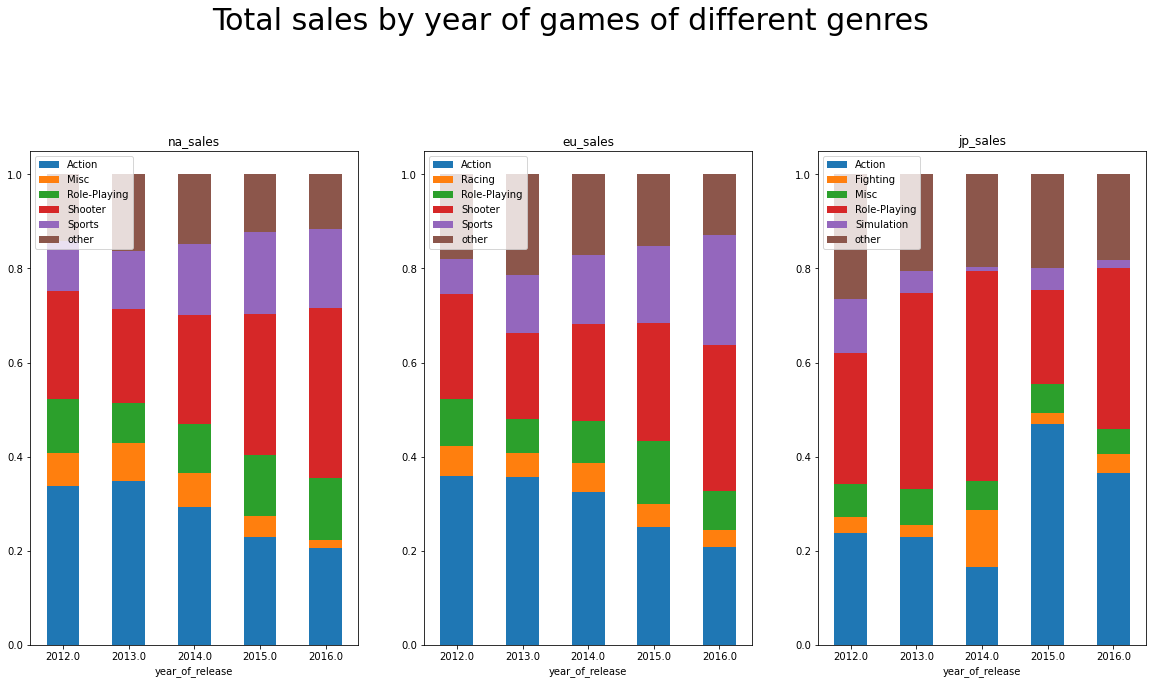

In [67]:
fig = plt.figure(figsize=(20,20))
fig.suptitle('Total sales by year of games of different genres', fontsize = 30)
region = ['na_sales','eu_sales','jp_sales']
ax = []
for i in range(3):
    cross_tab_prop = pd.crosstab(index=dfs[i]['year_of_release'],
                                columns=dfs[i]['genre'],
                                values = dfs[i][region[i]],
                                aggfunc='sum',
                                normalize="index")
    ax1 = plt.subplot(2, 3, i+1)
    cross_tab_prop.plot.bar(ax=ax1,rot = 0, stacked = True)
    ax1.set_title(region[i])
    ax1.legend(loc = 'upper left')
plt.show()

America: Action, shooters and sports have been and remain consistently popular genres, basically the popularity of genres has remained the same every year, Americans do not change their preferences.

Europe: The percentage ratio for the games does not change much over the years, as with the Americans, and the picture also turns out to be very similar to the American situation, except that racing is more popular in Europe

Japan: As expected, the situation is completely different than in previous regions, role-playing games occupy the lion's share of copies sold every year, action games have also gained popularity in the last two years, simulators were much more popular in 2012-2013, in general, the percentage of genres by year is less stable than in other regions, but the rating every year almost identical

Now let's analyze the dependence of sales on the ESRB rating for each of the regions

<Figure size 432x288 with 0 Axes>

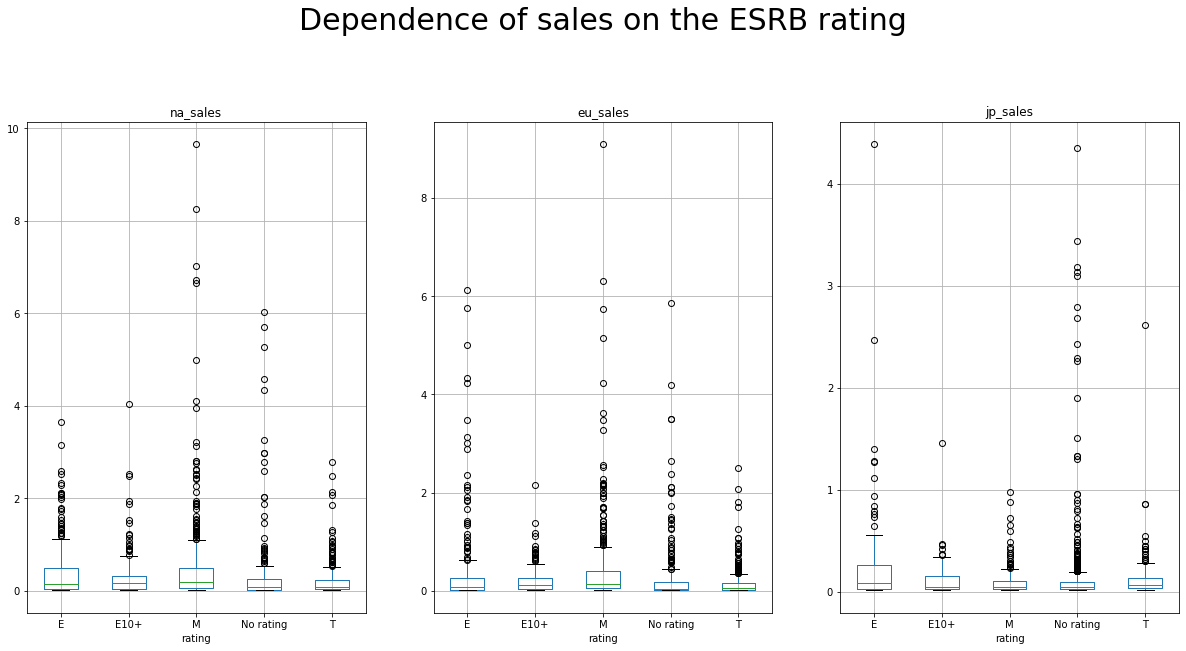

<Figure size 432x288 with 0 Axes>

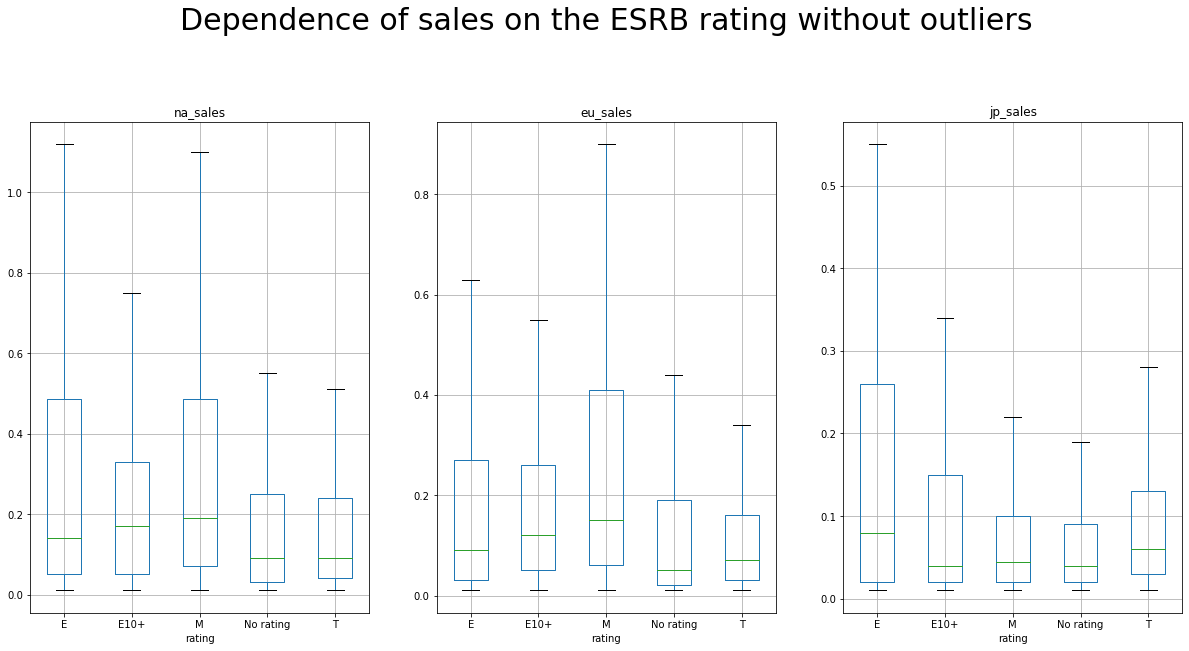

In [68]:
plt.figure(1)
fig = plt.figure(figsize=(20,20))
region = ['na_sales','eu_sales','jp_sales']
for i in range(3):
    ax1 = plt.subplot(2, 3, i+1)
    data[data[region[i]] != 0].boxplot(ax = ax1, column = region[i],by = 'rating', figsize= (15,20))
    ax1.set_title(region[i])
fig.suptitle('Dependence of sales on the ESRB rating', fontsize = 30)
plt.show()
plt.figure(2)
fig = plt.figure(figsize=(20,20))
for i in range(3):
    ax1 = plt.subplot(2, 3, i+1)
    data[data[region[i]] != 0].boxplot(ax = ax1, column = region[i],by = 'rating', figsize= (15,20), showfliers = False)
    ax1.set_title(region[i])
fig.suptitle('Dependence of sales on the ESRB rating without outliers', fontsize = 30)
plt.show()


America: Median values at a fairly low level, as well as quartiles, for almost all ratings, the biggest difference in the number of sales for 75% for games rated M(17+) and E(everyone). We see a lot of outliers for almost every age limit, it means that there are popular and very well-selling games in America in any age categories. Games for any age, 17+ games and games without a rating have the most outliers. The most unsold games are in the genre T(13+), outliers are also low there

Europe: The M rating (17+) stands out with big sales compared to other ratings, again there are a lot of outliers, as in America, more outliers are from games with M ratings, the most unsold games are in the T genre (13+), the median is again very low

Japan: again, we see a completely different situation, the games with the largest number of copies sold are games with an E rating (for any age). The medians are also quite low, the strongest outliers are from games that do not have a rating, games with an M rating sell the worst, which is quite logical, the Japanese are not big fans of violence and similar things in games.

### Hypothesis testing

Hypothesis 1: *The average user ratings of the Xbox One and PC platforms are the same*

In [69]:
data[data['platform'] == 'XOne']['year_of_release'].min()

2013.0

The XOne console was released only in 2013, so in order to align the periods of use of the platforms, we will consider only data on PC games from 2013

In [70]:
print('The number of games on the Xbox platform with user ratings = ',len(data[data['platform'] == 'XOne'].dropna(subset = ['user_score'])))
print('The number of games on the PC platform with user ratings = ',len(data.loc[(data['platform'] == 'PC') & (data['year_of_release'] >= 2013)].dropna(subset = ['user_score'])))

The number of games on the Xbox platform with user ratings =  182
The number of games on the PC platform with user ratings =  155


This is a hypothesis about the equality of the averages of two general aggregates.

Null hypothesis: Average user ratings for the Xbox One platform = average user ratings for the PC platform.

Alternative hypothesis: Average user ratings for the Xbox One platform!= average user ratings for the PC platform.

To test this hypothesis, we will use the `scipy.stats.ttest_ind()` method, we will use Welch's t-test for two independent samples, since in our case the samples are of different sizes, the general aggregates (user ratings of the two platforms) are independent, and thanks to the central limit theorem, since our samples are large enough, the sample averages of each generational population are distributed normally 

We will set the critical level of statistical significance equal to 5%

In [71]:
alpha = 0.05
results = st.ttest_ind(
    data[data['platform'] == 'XOne']['user_score'].dropna(), 
    data[data['platform'] == 'PC']['user_score'].dropna(), equal_var=False)
print('p-значение:', results.pvalue)
if results.pvalue < alpha :
    print('We reject the null hypothesis')
else:
    print('The null hypothesis could not be rejected')

p-значение: 0.5489537965134912
The null hypothesis could not be rejected


The probability of getting the same or greater difference, assumed that the average user ratings for the Xbox One platform = the average user ratings for the PC platform - p-value - is more than 54%, therefore we cannot reject the null hypothesis about the equality of the average two platforms. Based on our test, the data does not contradict the hypothesis.

Hypothesis 2: *Average user ratings of Action and Sports genres are different*

In [72]:
print('Number of Action genre games with user ratings = ',len(data[data['genre'] == 'Action'].dropna(subset = ['user_score'])))
print('Number of Sports genre games with user ratings = ',len(data[data['genre'] == 'Sports'].dropna(subset = ['user_score'])))

Number of Action genre games with user ratings =  523
Number of Sports genre games with user ratings =  195


Null hypothesis: Average user ratings of the Action genre = average user ratings of the Sports genre.

Alternative hypothesis: average user ratings of the Action genre!= average user ratings of the Sports genre.

To test this hypothesis, we will use the `scipy.stats.ttest_ind()` method, that is, we will use Welch's t-test for two independent samples, since in our case samples are of different sizes, general aggregates (user ratings of two genres) are independent, and thanks to the central limit theorem, since our samples are large enough, the sample averages of each generational population are distributed normally 

We will set the critical level of statistical significance equal to 5%

In [73]:
alpha = 0.05
results = st.ttest_ind(
    data[data['genre'] == 'Action']['user_score'].dropna(), 
    data[data['genre'] == 'Sports']['user_score'].dropna(), equal_var=False)
print('p-значение:', results.pvalue)
if results.pvalue < alpha :
    print('We reject the null hypothesis')
else:
    print('The null hypothesis could not be rejected')

p-значение: 4.24307776572644e-20
We reject the null hypothesis


The probability of getting the same or greater difference, assumed that the average of user ratings of the Action genre = the average of user ratings of the Sports genre -p-value - is very small, therefore we reject the null hypothesis of equality of averages and accept the alternative hypothesis of inequality of the two averages. Hypothesis 2 is correct.

### Conclusions:
Data preprocessing was carried out, namely: bringing columns to the lower case, processing omissions, creating columns for the convenience of further analysis
An exploratory data analysis was carried out, it revealed the following data features that will help plan the store's campaign for 2017
1. After 2011, there was a noticeable decline in the release of new games
2. Platforms with the highest sales of all time - PS2, X360, PS3, Wii,DS, however, sales of new games on these platforms are very small, compared to sales previously
3. The lifetime of the platforms is 10-12 years
4. The current period for forecasting was highlighted: games released after 2012 (inclusive)
5. Platforms with the highest sales of games from 2012 to 2016 - PS4,PS3,X360,3DS,XOne
6. The most promising platforms: PS4,3DS,XOne
7. Most of the games on the platforms are sold with a very small number of copies, but almost every platform has games with outstanding sales
8. There are a lot of intersections in the top of all platforms for games
9. There is no strong correlation between the critics' score and the number of sales, but if the critic's score is less than 60, then this is an unpopular game
10. The dependence of the number of sales on user ratings is even weaker, but it can still be argued that if the score is less than 4, then these are mostly unpopular games
11. Most of the games during this period since 2012 have been produced in the action genre, also quite a lot of games come out in the genre of role-playing games, least of all - simulators, puzzles and strategies
12. At the moment, puzzles have almost lost their relevance, more and more action is being released
13. A very promising genre - shooters
14. The average number of copies sold is quite small for the action genre, although a lot of games are produced in this genre
15.  Genres of sports and platformers are consistently successful
16. Promising platforms for America and Europe: PS4, XOne.
17. There are fewer sales in Japan than in other areas
18. Xbox is much less popular in Japan than in other areas, in Japan, preference is given to handheld consoles
19. The most promising platforms in Japan are 3DS, PSV, PS4,
20. Preferences in games in Japan are very different from other regions
21. Action, shooters and sports are consistently popular genres for America and Europe, role-playing games are also quite popular
22. The top genres in Japan differ from other areas: role-playing games come first, then action, simulators and fighting games
23. For America, the biggest difference in the number of sales  for 75% is with an M rating, the smallest is for games with a T rating
24. There are very well-selling games in America and Europe in all age categories
25. In Europe, the M rating stands out for big sales
26. In Japan, the games with the highest number of copies sold are E-rated games, M-rated games sell the worst
27. The average user ratings of the XOne and PC platforms can be considered equal, based on the conducted t-test
28. Average user ratings of Action and Sport genres are different